<a href="https://colab.research.google.com/github/wannasmile/colab_code_note/blob/main/SIMFLW02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
''' Operation classes in computational graph.
'''
from queue import Queue

import numpy as np

class Operation(object):
    ''' Base class for all operations in simpleflow.
    An operation is a node in computational graph receiving zero or more nodes
    as input and produce zero or more nodes as output. Vertices could be an
    operation, variable or placeholder.
    '''
    def __init__(self, *input_nodes, name=None):
        ''' Operation constructor.
        :param input_nodes: Input nodes for the operation node.
        :type input_nodes: Objects of `Operation`, `Variable` or `Placeholder`.
        :param name: The operation name.
        :type name: str.
        '''
        # Nodes received by this operation.
        self.input_nodes = input_nodes

        # Nodes that receive this operation node as input.
        self.output_nodes = []

        # Output value of this operation in session execution.
        self.output_value = None

        # Operation name.
        self.name = name

        # Graph the operation belongs to.
        self.graph = DEFAULT_GRAPH

        # Add this operation node to destination lists in its input nodes.
        for node in input_nodes:
            node.output_nodes.append(self)

        # Add this operation to default graph.
        self.graph.operations.append(self)

    def compute_output(self):
        ''' Compute and return the output value of the operation.
        '''
        raise NotImplementedError

    def compute_gradient(self, grad=None):
        ''' Compute and return the gradient of the operation wrt inputs.
        '''
        raise NotImplementedError

    def __add__(self, other):
        return Add(self, other)

    def __neg__(self):
        return Negative(self)

    def __sub__(self, other):
        return Add(self, Negative(other))

    def __mul__(self, other):
        return Multiply(self, other)

# ------------------------------------------------------------------------------
# Addition operation
# ------------------------------------------------------------------------------

class Add(Operation):
    ''' An addition operation.
    '''
    def __init__(self, x, y, name=None):
        ''' Addition constructor.
        :param x: The first input node.
        :type x: Object of `Operation`, `Variable` or `Placeholder`.
        :param y: The second input node.
        :type y: Object of `Operation`, `Variable` or `Placeholder`.
        :param name: The operation name.
        :type name: str.
        '''
        super(self.__class__, self).__init__(x, y, name=name)

    def compute_output(self):
        ''' Compute and return the value of addition operation.
        '''
        x, y = self.input_nodes
        self.output_value = np.add(x.output_value, y.output_value)
        return self.output_value

    def compute_gradient(self, grad=None):
        ''' Compute the gradients for this operation wrt input values.
        :param grad: The gradient of other operation wrt the addition output.
        :type grad: number or a ndarray, default value is 1.0.
        '''
        x, y = [node.output_value for node in self.input_nodes]

        if grad is None:
            grad = np.ones_like(self.output_value)

        grad_wrt_x = grad
        while np.ndim(grad_wrt_x) > len(np.shape(x)):
            grad_wrt_x = np.sum(grad_wrt_x, axis=0)
        for axis, size in enumerate(np.shape(x)):
            if size == 1:
                grad_wrt_x = np.sum(grad_wrt_x, axis=axis, keepdims=True)

        grad_wrt_y = grad
        while np.ndim(grad_wrt_y) > len(np.shape(y)):
            grad_wrt_y = np.sum(grad_wrt_y, axis=0)
        for axis, size in enumerate(np.shape(y)):
            if size == 1:
                grad_wrt_y = np.sum(grad_wrt_y, axis=axis, keepdims=True)

        return [grad_wrt_x, grad_wrt_y]

def add(x, y, name=None):
    ''' Returns x + y element-wise.
    '''
    return Add(x, y, name)

# ------------------------------------------------------------------------------
# Multiplication operation
# ------------------------------------------------------------------------------

class Multiply(Operation):
    ''' Multiplication operation.
    '''
    def __init__(self, x, y, name=None):
        ''' Multiplication constructor.
        :param x: The first input node.
        :type x: Object of `Operation`, `Variable` or `Placeholder`.
        :param y: The second input node.
        :type y: Object of `Operation`, `Variable` or `Placeholder`.
        :param name: The operation name.
        :type name: str.
        '''
        super(self.__class__, self).__init__(x, y, name=name)

    def compute_output(self):
        ''' Compute and return the multiplication operation result.
        '''
        x, y = self.input_nodes
        self.output_value = np.multiply(x.output_value, y.output_value)
        return self.output_value

    def compute_gradient(self, grad=None):
        ''' Compute and return gradients for this operation wrt input values.
        :param grad: The gradient of other operation wrt the mutiply output.
        :type grad: number or a ndarray.
        '''
        x, y = [node.output_value for node in self.input_nodes]

        if grad is None:
            grad = np.ones_like(self.output_value)

        grad_wrt_x = grad*y
        while np.ndim(grad_wrt_x) > len(np.shape(x)):
            grad_wrt_x = np.sum(grad_wrt_x, axis=0)
        for axis, size in enumerate(np.shape(x)):
            if size == 1:
                grad_wrt_x = np.sum(grad_wrt_x, axis=axis, keepdims=True)

        grad_wrt_y = grad*x
        while np.ndim(grad_wrt_y) > len(np.shape(y)):
            grad_wrt_y = np.sum(grad_wrt_y, axis=0)
        for axis, size in enumerate(np.shape(y)):
            if size == 1:
                grad_wrt_y = np.sum(grad_wrt_y, axis=axis, keepdims=True)

        return [grad_wrt_x, grad_wrt_y]

def multiply(x, y, name=None):
    ''' Returns x * y element-wise.
    '''
    return Multiply(x, y, name)

# ------------------------------------------------------------------------------
# Matrix multiplication operation
# ------------------------------------------------------------------------------

class MatMul(Operation):
    ''' Matrix multiplication operation.
    '''
    def __init__(self, x, y, name=None):
        ''' MatMul constructor.
        :param x: The first input node.
        :type x: Object of `Operation`, `Variable` or `Placeholder`.
        :param y: The second input node.
        :type y: Object of `Operation`, `Variable` or `Placeholder`.
        :param name: The operation name.
        :type name: str.
        '''
        super(self.__class__, self).__init__(x, y, name=name)

    def compute_output(self):
        ''' Compute and return the multiplication operation result.
        '''
        x, y = self.input_nodes
        self.output_value = np.dot(x.output_value, y.output_value)
        return self.output_value

    def compute_gradient(self, grad=None):
        ''' Compute and return the gradient for matrix multiplication.
        :param grad: The gradient of other operation wrt the matmul output.
        :type grad: number or a ndarray, default value is 1.0.
        '''
        # Get input values.
        x, y = [node.output_value for node in self.input_nodes]

        # Default gradient wrt the matmul output.
        if grad is None:
            grad = np.ones_like(self.output_value)

        # Gradients wrt inputs.
        dfdx = np.dot(grad, np.transpose(y))
        dfdy = np.dot(np.transpose(x), grad)

        return [dfdx, dfdy]

def matmul(x, y, name=None):
    ''' Multiplies matrix `a` by matrix `b`, producing `a` * `b`.
    '''
    return MatMul(x, y, name)

# ------------------------------------------------------------------------------
# Sigmoid operation
# ------------------------------------------------------------------------------

class Sigmoid(Operation):
    ''' Sigmoid operation.
    '''
    def __init__(self, x, name=None):
        ''' Sigmoid operation constructor.
        :param x: The input node.
        :type x: Object of `Operation`, `Variable` or `Placeholder`.
        :param name: The operation name.
        :type name: str.
        '''
        super(self.__class__, self).__init__(x, name=name)

    def compute_output(self):
        ''' Compute and return the value of sigmoid function.
        '''
        x, = self.input_nodes
        self.output_value = 1/(1 + np.exp(-x.output_value))
        return self.output_value

    def compute_gradient(self, grad=None):
        ''' Compute the gradient for sigmoid operation wrt input value.
        :param grad: The gradient of other operation wrt the sigmoid output.
        :type grad: ndarray.
        '''
        if grad is None:
            grad = np.ones_like(self.output_value)
        return grad*self.output_value*(1 - self.output_value)

def sigmoid(x, name=None):
    ''' Computes sigmoid of `x` element-wise.
    '''
    return Sigmoid(x, name=name)

# ------------------------------------------------------------------------------
# Logarithm operation
# ------------------------------------------------------------------------------

class Log(Operation):
    ''' Natural logarithm operation.
    '''
    def __init__(self, x, name=None):
        ''' Logarithm constructor.
        :param x: The input node.
        :type x: Object of `Operation`, `Variable` or `Placeholder`.
        :param name: The operation name.
        :type name: str.
        '''
        super(self.__class__, self).__init__(x, name=name)

    def compute_output(self):
        ''' Compute and return the value of sigmoid function.
        '''
        x, = self.input_nodes
        self.output_value = np.log(x.output_value)
        return self.output_value

    def compute_gradient(self, grad=None):
        ''' Compute the gradient for natural logarithm operation wrt input value.
        :param grad: The gradient of other operation wrt the logarithm output.
        :type grad: ndarray.
        '''
        x = self.input_nodes[0].output_value
        if grad is None:
            grad = np.ones_like(self.output_value)
        return grad*1/x

def log(x, name=None):
    ''' Computes the natural logarithm of x element-wise.
    '''
    return Log(x, name=name)

# ------------------------------------------------------------------------------
# Negative operation
# ------------------------------------------------------------------------------

class Negative(Operation):
    ''' Negative operation.
    '''
    def __init__(self, x, name=None):
        ''' Operation constructor.
        :param x: The input node.
        :type x: Object of `Operation`, `Variable` or `Placeholder`.
        :param name: The operation name.
        :type name: str.
        '''
        super(self.__class__, self).__init__(x, name=name)

    def compute_output(self):
        ''' Compute and return the value of sigmoid function.
        '''
        x, = self.input_nodes
        self.output_value = -x.output_value
        return self.output_value

    def compute_gradient(self, grad=None):
        ''' Compute the gradient for negative operation wrt input value.
        :param grad: The gradient of other operation wrt the negative output.
        :type grad: ndarray.
        '''
        if grad is None:
            grad = np.ones_like(self.output_value)
        return -grad

# ------------------------------------------------------------------------------
# Reduce sum operation
# ------------------------------------------------------------------------------

class ReduceSum(Operation):
    ''' Reduce sum operation.
    '''
    def __init__(self, x, axis=None):
        ''' Operation constructor.
        :param x: The input node.
        :type x: Object of `Operation`, `Variable` or `Placeholder`.
        :param axis: The dimensions to reduce. If `None`, reduces all dimensions.
        :type axis: int.
        '''
        super(self.__class__, self).__init__(x)
        self.axis = axis

    def compute_output(self):
        ''' Compute and return the value of sigmoid function.
        '''
        x, = self.input_nodes
        self.output_value = np.sum(x.output_value, self.axis)
        return self.output_value

    def compute_gradient(self, grad=None):
        ''' Compute the gradient for negative operation wrt input value.
        :param grad: The gradient of other operation wrt the negative output.
        :type grad: ndarray.
        '''
        input_value = self.input_nodes[0].output_value

        if grad is None:
            grad = np.ones_like(self.output_value)

        output_shape = np.array(np.shape(input_value))
        output_shape[self.axis] = 1.0
        tile_scaling = np.shape(input_value) // output_shape
        grad = np.reshape(grad, output_shape)
        return np.tile(grad, tile_scaling)

def reduce_sum(x, axis=None):
    ''' Computes the sum of elements across dimensions of a tensor.
    '''
    return ReduceSum(x, axis=axis)

# ------------------------------------------------------------------------------
# Square operation
# ------------------------------------------------------------------------------

class Square(Operation):
    ''' Square operation.
    '''
    def __init__(self, x, name=None):
        ''' Operation constructor.
        :param x: The input node.
        :type x: Object of `Operation`, `Variable` or `Placeholder`.
        :param name: The name of the operation.
        :type name: str.
        '''
        super(self.__class__, self).__init__(x, name=name)

    def compute_output(self):
        ''' Compute and return the value of square function.
        '''
        x, = self.input_nodes
        self.output_value = np.square(x.output_value)
        return self.output_value

    def compute_gradient(self, grad=None):
        ''' Compute the gradient for square operation wrt input value.
        :param grad: The gradient of other operation wrt the square output.
        :type grad: ndarray.
        '''
        input_value = self.input_nodes[0].output_value

        if grad is None:
            grad = np.ones_like(self.output_value)

        return grad*np.multiply(2.0, input_value)

def square(x, name=None):
    ''' Computes square of x element-wise.
    '''
    return Square(x, name=name)

# ------------------------------------------------------------------------------
# Constant node
# ------------------------------------------------------------------------------

class Constant(object):
    ''' Constant node in computational graph.
    '''
    def __init__(self, value, name=None):
        ''' Cosntant constructor.
        '''
        # Constant value.
        self.value = value

        # Output value of this operation in session.
        self.output_value = None

        # Nodes that receive this variable node as input.
        self.output_nodes = []

        # Operation name.
        self.name = name

        # Add to graph.
        DEFAULT_GRAPH.constants.append(self)

    def compute_output(self):
        ''' Compute and return the constant value.
        '''
        if self.output_value is None:
            self.output_value = self.value
        return self.output_value

    def __add__(self, other):
        return Add(self, other)

    def __neg__(self):
        return Negative(self)

    def __sub__(self, other):
        return Add(self, Negative(other))

    def __mul__(self, other):
        return Multiply(self, other)

def constant(value, name=None):
    ''' Create a constant node.
    '''
    return Constant(value, name=name)

# ------------------------------------------------------------------------------
# Variable node
# ------------------------------------------------------------------------------

class Variable(object):
    ''' Variable node in computational graph.
    '''
    def __init__(self, initial_value=None, name=None, trainable=True): 
        ''' Variable constructor.
        :param initial_value: The initial value of the variable.
        :type initial_value: number or a ndarray.
        :param name: Name of the variable.
        :type name: str.
        '''
        # Variable initial value.
        self.initial_value = initial_value

        # Output value of this operation in session execution.
        self.output_value = None

        # Nodes that receive this variable node as input.
        self.output_nodes = []

        # Variable name.
        self.name = name

        # Graph the variable belongs to.
        self.graph = DEFAULT_GRAPH

        # Add to the currently active default graph.
        self.graph.variables.append(self)
        if trainable:
            self.graph.trainable_variables.append(self)

    def compute_output(self):
        ''' Compute and return the variable value.
        '''
        if self.output_value is None:
            self.output_value = self.initial_value
        return self.output_value

    def __add__(self, other):
        return Add(self, other)

    def __neg__(self):
        return Negative(self)

    def __sub__(self, other):
        return Add(self, Negative(other))

    def __mul__(self, other):
        return Multiply(self, other)

# ------------------------------------------------------------------------------
# Placeholder node
# ------------------------------------------------------------------------------

class Placeholder(object):
    ''' Placeholder node in computational graph. It has to be provided a value when
        when computing the output of a graph.
    '''
    def __init__(self, name=None):
        ''' Placeholdef constructor.
        '''
        # Output value of this operation in session execution.
        self.output_value = None

        # Nodes that receive this placeholder node as input.
        self.output_nodes = []

        # Placeholder node name.
        self.name = name

        # Graph the placeholder node belongs to.
        self.graph = DEFAULT_GRAPH

        # Add to the currently active default graph.
        self.graph.placeholders.append(self)

    def __add__(self, other):
        return Add(self, other)

    def __neg__(self):
        return Negative(self)

    def __sub__(self, other):
        return Add(self, Negative(other))

    def __mul__(self, other):
        return Multiply(self, other)

def placeholder(name=None):
    ''' Inserts a placeholder for a node that will be always fed.
    '''
    return Placeholder(name=name)

# ------------------------------------------------------------------------------
# Function for gradients computation.
# ------------------------------------------------------------------------------

def compute_gradients(target_op):
    ''' Backpropagation implementation computing gradient of target operation wrt
        all the other connected nodes.
    :param target_op: The target operation whose gradient wrt other nodes would
                      be computed.
    :type target_op: Any operation type.
    :return grad_table: A table containing node objects and gradients.
    :type grad_table: dict.
    '''
    # A dict containing a mapping between node and gradient value of target_op wrt the node's output.
    # NOTE: It is the gradient wrt the node's OUTPUT NOT input.
    grad_table = {}

    # The gradient wrt target_op itself is 1.
    grad_table[target_op] = np.ones_like(target_op.output_value)

    # Perform a breadth-first search staring from the target_op in graph.
    # Queue for node traverasl.
    queue = Queue()
    queue.put(target_op)

    # Set for visited nodes.
    visited = set()
    visited.add(target_op)

    while not queue.empty():
        node = queue.get()

        # Compute gradient wrt the node's output.
        if node != target_op:
            grads_wrt_node_output = []

            for output_node in node.output_nodes:
                # Retrieve the gradient wrt output_node's OUTPUT.
                grad_wrt_output_node_output = grad_table[output_node]

                # Compute the gradient wrt current node's output.
                grad_wrt_node_output = output_node.compute_gradient(grad_wrt_output_node_output)
                if len(output_node.input_nodes) > 1:
                    input_node_index = output_node.input_nodes.index(node)
                    grads_wrt_node_output.append(grad_wrt_node_output[input_node_index])
                else:
                    grads_wrt_node_output.append(grad_wrt_node_output)

            # Sum all gradients wrt node's output.
            tot_grad_wrt_node_output = sum(grads_wrt_node_output)
            grad_table[node] = tot_grad_wrt_node_output

        # Put adjecent nodes to queue.
        if hasattr(node, 'input_nodes'):
            for input_node in node.input_nodes:
                if input_node not in visited:
                    visited.add(input_node)
                    queue.put(input_node)

    return grad_table


#!/usr/bin/env python
# -*- coding: utf-8 -*-
''' Computational graph definition.
'''

class Graph(object):
    ''' Graph containing all computing nodes.
    '''
    def __init__(self):
        ''' Graph constructor.
        '''
        self.operations, self.constants, self.placeholders = [], [], []
        self.variables, self.trainable_variables = [], []

    def __enter__(self):
        ''' Reset default graph.
        '''
        global DEFAULT_GRAPH
        self.old_graph = DEFAULT_GRAPH
        DEFAULT_GRAPH = self
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        ''' Recover default graph.
        '''
        global DEFAULT_GRAPH
        DEFAULT_GRAPH = self.old_graph

    def as_default(self):
        ''' Set this graph as global default graph.
        '''
        return self


#!/usr/bin/env python
# -*- coding: utf-8 -*-
''' Session to execute a computational graph.
'''
from functools import reduce

#from .operations import Operation, Variable, Placeholder

class Session(object):
    ''' A session to compute a particular graph.
    '''
    def __init__(self):
        ''' Session constructor.
        '''
        # Graph the session computes for.
        self.graph = DEFAULT_GRAPH

    def __enter__(self):
        ''' Context management protocal method called before `with-block`.
        '''
        return self

    def __exit__(self, exc_type, exc_value, exc_tb):
        ''' Context management protocal method called after `with-block`.
        '''
        self.close()

    def close(self):
        ''' Free all output values in nodes.
        '''
        all_nodes = (self.graph.constants + self.graph.variables +
                     self.graph.placeholders + self.graph.operations +
                     self.graph.trainable_variables)
        for node in all_nodes:
            node.output_value = None

    def run(self, operation, feed_dict=None):
        ''' Compute the output of an operation.
        :param operation: A specific operation to be computed.
        :type operation: object of `Operation`, `Variable` or `Placeholder`.
        :param feed_dict: A mapping between placeholder and its actual value for the session.
        :type feed_dict: dict.
        '''
        # Get all prerequisite nodes using postorder traversal.
        postorder_nodes = _get_prerequisite(operation)

        for node in postorder_nodes:
            if type(node) is Placeholder:
                node.output_value = feed_dict[node]
            else:  # Operation and variable
                node.compute_output()

        return operation.output_value

def _get_prerequisite(operation):
    ''' Perform a post-order traversal to get a list of nodes to be computed in order.
    '''
    postorder_nodes = []

    # Collection nodes recursively.
    def postorder_traverse(operation):
        if isinstance(operation, Operation):
            for input_node in operation.input_nodes:
                postorder_traverse(input_node)
        postorder_nodes.append(operation)

    postorder_traverse(operation)

    return postorder_nodes



#!/usr/bin/env python
# -*- coding: utf-8 -*-
''' Optimizer classes for parameters optimization.
'''
#from .operations import Operation, compute_gradients

class GradientDescentOptimizer(object):
    ''' Optimizer that implements the gradient descent algorithm.
    '''
    def __init__(self, learning_rate):
        ''' Construct a new gradient descent optimizer
        :param learning_rate: learning rate of optimizier.
        :type learning_rate: float
        '''
        self.learning_rate = learning_rate

    def minimize(self, loss):
        ''' Generate an gradient descent optimization operation for loss.
        :param loss: The loss operation to be optimized.
        :type loss: Object of `Operation`
        '''
        learning_rate = self.learning_rate

        class MinimizationOperation(Operation):
            def compute_output(self):
                # Get gradient table.
                grad_table = compute_gradients(loss)

                # Iterate all trainable variables in graph.
                for var in DEFAULT_GRAPH.trainable_variables:
                    if var in grad_table:
                        grad = grad_table[var]

                    # Update its output value.
                    var.output_value -= learning_rate*grad

        return MinimizationOperation()



import builtins
DEFAULT_GRAPH = builtins.DEFAULT_GRAPH = Graph()



In [2]:
with Graph().as_default():
    a = constant(1.0, name='a')
    b = constant(2.0, name='b')
    result = a + b
    
    # Create a session to run the graph
    with Session() as sess:
        print(sess.run(result))

3.0


In [3]:
with Graph().as_default():
    a = constant([[2.0, 2.0, 3.0], [3.0, 3.0, 3.0]], name='ma')
    b = constant([3.0, 4.0, 5.0], name='mb')
    result = matmul(a, b)
    
    with Session() as sess:
        print(sess.run(result))

[29. 36.]


In [4]:
import numpy as np
import matplotlib.pyplot as plt

input_x = np.linspace(-1, 1, 100)
input_y = input_x*3 + np.random.randn(input_x.shape[0])*0.5

In [5]:
# Placeholders for training data
x = Placeholder()
y_ = Placeholder()

# Weigths
w = Variable([[1.0]], name='weight')

# Threshold
b = Variable(0.0, name='threshold')


# Predicted class by model
y = x*w + b


loss = reduce_sum(square(y - y_))

train_op = GradientDescentOptimizer(learning_rate=0.005).minimize(loss)

feed_dict = {x: np.reshape(input_x, (-1, 1)), y_: np.reshape(input_y, (-1, 1))}
feed_dict = {x: input_x, y_: input_y}
with Session() as sess:
    for step in range(20):
        loss_value = sess.run(loss, feed_dict=feed_dict)
        mse = loss_value/len(input_x)
        
        if step % 1 == 0:
            print('step: {}, loss: {}, mse: {}'.format(step, loss_value, mse))
        sess.run(train_op, feed_dict)
    w_value = sess.run(w, feed_dict=feed_dict)
    b_value = sess.run(b, feed_dict=feed_dict)
    print('w: {}, b: {}'.format(w_value, b_value))

step: 0, loss: 180.47701615594883, mse: 1.8047701615594882
step: 1, loss: 94.42297046815727, mse: 0.9442297046815727
step: 2, loss: 57.038230997407, mse: 0.57038230997407
step: 3, loss: 40.756761402373115, mse: 0.40756761402373115
step: 4, loss: 33.66600041468682, mse: 0.3366600041468682
step: 5, loss: 30.57789518616188, mse: 0.3057789518616188
step: 6, loss: 29.232991032855367, mse: 0.29232991032855365
step: 7, loss: 28.64727032461219, mse: 0.2864727032461219
step: 8, loss: 28.392182445508347, mse: 0.28392182445508346
step: 9, loss: 28.281088838692117, mse: 0.28281088838692114
step: 10, loss: 28.23270633804647, mse: 0.2823270633804647
step: 11, loss: 28.211635221212546, mse: 0.28211635221212544
step: 12, loss: 28.2024585156123, mse: 0.282024585156123
step: 13, loss: 28.198461958318386, mse: 0.2819846195831839
step: 14, loss: 28.196721413192567, mse: 0.28196721413192566
step: 15, loss: 28.195963386442994, mse: 0.28195963386442996
step: 16, loss: 28.195633257367597, mse: 0.2819563325736

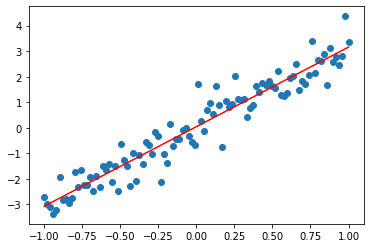

In [6]:
w_value = float(w_value)
max_x, min_x = np.max(input_x), np.min(input_x)
max_y, min_y = w_value*max_x + b_value, w_value*min_x + b_value

plt.plot([max_x, min_x], [max_y, min_y], color='r')
plt.scatter(input_x, input_y)
plt.show()